## 006.Missing data within a "gene" (cluster)
- normalized distance matrices seem to work well for missing  data, but it might be due to "same clusters" having more leaves in common
- new simulation (compared to 005) allows for missing data within a gene

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import sys, subprocess, time, dendropy, os, copy
import numpy as np
from sklearn import manifold, metrics, cluster, neighbors, decomposition, preprocessing
import treesignal

In [18]:
## quick-and-dirty function: user must make sure that gene_chain has enough species
def generate_gene_families(n_species = 32, n_samples=5, n_families=5, n_missing=1, n_spr=1):
    #split chain: sptrees --- gt1 --- sptrees --- gt2 --- ... --- sptrees --- gt_n --- sptrees # 
    # sptrees blocks are twice as long as genetree blocks: 2 X n_s X (n_f +1)
    sp_factor = 3
    min_sp = 6
    n_trees = n_samples * n_families + sp_factor * n_samples * (n_families+1) 
    # generate a SPR chain with "complete" trees
    gf = treesignal.TreeSignal(n_species = n_species, chain_size = n_trees, n_spr = n_spr, pvalue=True)
    if (n_species - n_missing) < min_sp: # T1...T4 (or 4 first species) always present 
        n_missing = n_species - min_sp
    # creation of new sptree set, excluding gene trees
    full_sptrees = gf.sp_trees[:sp_factor*n_samples] 
    for i in range(n_families):
        start = (sp_factor+1)*n_samples*(i+1)
        for j in range(start,start+sp_factor*n_samples):
            full_sptrees.append(gf.sp_trees[j])
        
    # creation of gene trees, each family will have distinct missing data
    all_tx_miss = [] # list with all pruned species
    gt_missing = []  # genes with a few missing taxa
    gt_all_pruned = [] # genes pruned s.t. all have same taxa (i.e. smaller than gt_missing)
    for i in range(n_families):
        start = sp_factor*n_samples*(i+1)
        for t in gf.sp_trees[start:start+n_samples]:
            tx_miss = np.random.permutation(gf.sp_trees.taxon_namespace[min_sp:])[:n_missing]
            tx_miss = [x.label for x in tx_miss]
            all_tx_miss.append(tx_miss) # is a list of lists
            t2 = t.extract_tree_without_taxa_labels(labels=tx_miss)
            gt_missing.append(dendropy.Tree.get(data=t2.as_string(schema="newick"),schema="newick"))            
            gt_all_pruned.append(copy.deepcopy(t))
    # gt_all_pruned now will have only taxa in common
    all_tx_miss = list(set([x0 for x in all_tx_miss for x0 in x]))
    for t in gt_all_pruned:
        t.prune_taxa_with_labels(all_tx_miss)
        
    gf.update_spstring_from_trees(full_sptrees)
    cols = np.repeat(range(n_families),n_samples)
    return gt_missing, gf, treesignal.TreeSignal(sp_trees = gt_all_pruned, pvalue=True), cols

gt, gf1, gf2, clabels = generate_gene_families(n_species = 32, n_samples=5, n_families = 6, n_missing=8, n_spr=3)
print (len(gf1.sp_trees), len(gf2.sp_trees), len(gt))
print (len(gf1.sp_trees.taxon_namespace), len(gf2.sp_trees.taxon_namespace))

105 30 30
32 6


In [19]:
# Reference trees and classical distmatrix distance 
feat_miss = gf2() 
feat_full = []
for t in gt:
    feat_full.append (gf1(t))
feat_full = np.array(feat_full)
print (feat_miss.shape, feat_full.shape)
# random trees
gf_random = treesignal.TreeSignal(n_species=len(gf1.sp_trees.taxon_namespace), chain_size=len(gf1.sp_trees)-1, n_spr=10)
feat_rand = []
for t in gt:
    feat_rand.append (gf_random(t))
feat_rand = np.array(feat_rand)
print (feat_rand.shape)

(30, 210) (30, 735)
(30, 735)


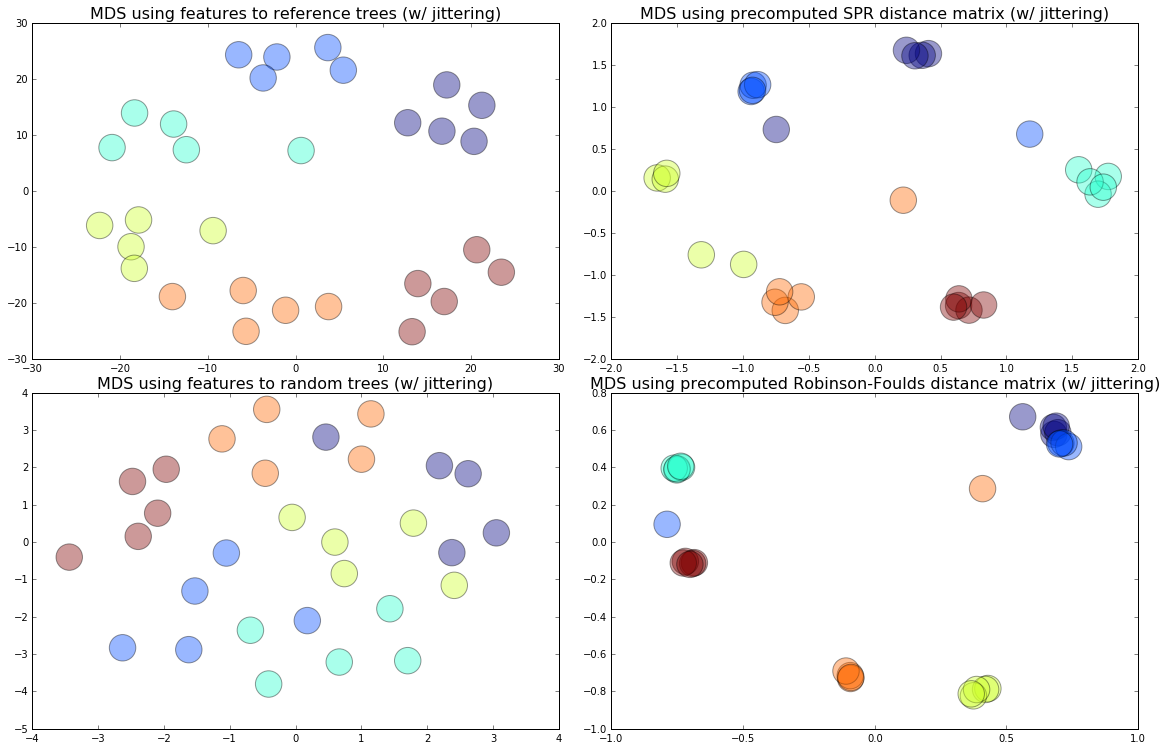

In [14]:
signal_full = feat_full / feat_full.mean(0); 
signal_miss = feat_miss / feat_miss.mean(0);
signal_rand = feat_rand / feat_rand.mean(0); 

fig, axes = plt.subplots(2,2) ; fig.set_size_inches(16, 10)
fig.subplots_adjust(top=.99, bottom=.01, left=.02, right=.98, wspace=.1, hspace=.1)

transf=manifold.MDS(n_components=2).fit_transform(signal_full)
#kmod1 = cluster.AgglomerativeClustering(n_clusters=6, affinity='cosine', linkage='average').fit(signal_full).labels_
jit = 0.01 * transf.max() * np.random.normal(size=feat_miss.shape[0]) # avoid complete overlap of points
axes[0,0].scatter(transf[:,1]+jit, transf[:,0]+jit[::-1], c=clabels,edgecolor="black", cmap="jet", alpha=.4, s=700)
#axes[0,0].scatter(transf[:,1]+jit, transf[:,0]+jit[::-1], c=kmod1, edgecolor="none", cmap="gnuplot", alpha=.5, s=30)
axes[0,0].set_title("MDS using features to reference trees (w/ jittering)",  fontsize=16)

transf=manifold.MDS(n_components=2).fit_transform(signal_rand)
#kmod1 = cluster.AgglomerativeClustering(n_clusters=6, affinity='cosine', linkage='average').fit(signal_rand).labels_
jit = 0.001 * transf.max() * np.random.normal(size=feat_rand.shape[0]) # avoid complete overlap of points
axes[1,0].scatter(transf[:,1]+jit, transf[:,0]+jit[::-1], c=clabels,edgecolor="black", cmap="jet", alpha=.4, s=700)
#axes[1,0].scatter(transf[:,1]+jit, transf[:,0]+jit[::-1], c=kmod1, edgecolor="none", cmap="gnuplot", alpha=.5, s=30)
axes[1,0].set_title("MDS using features to random trees (w/ jittering)",  fontsize=16)

dist1 = signal_miss[:,3::7] + signal_miss[:,4::7] # 3rd element is SPR (4 = spr residue, 5 = RF, 6 = Hdist)
dist1 = (dist1 + dist1.T)/2  # matrix must be symmetric
transf=manifold.MDS(n_components=2, dissimilarity="precomputed").fit_transform(dist1)
#kmod1 = cluster.AgglomerativeClustering(n_clusters=6, affinity='precomputed', linkage='average').fit(dist1).labels_
jit = 0.02 * transf.max() * np.random.normal(size=feat_miss.shape[0]) #  avoid complete overlap of points
axes[0,1].scatter(transf[:,1]+jit, transf[:,0]+jit[::-1], c=clabels, edgecolor="black", cmap="jet", alpha=.4, s=700)
#axes[0,1].scatter(transf[:,1]+jit, transf[:,0]+jit[::-1], c=kmod1, edgecolor="none", cmap="gnuplot", alpha=.5, s=30)
axes[0,1].set_title("MDS using precomputed SPR distance matrix (w/ jittering)",  fontsize=16)

dist2 = signal_miss[:,5::7] # 3rd element is SPR (4 = spr residue, 5 = RF, 6 = Hdist)
dist2 = (dist2 + dist2.T)/2  # matrix must be symmetric
transf=manifold.MDS(n_components=2, dissimilarity="precomputed").fit_transform(dist2)
#kmod1 = cluster.AgglomerativeClustering(n_clusters=6, affinity='precomputed', linkage='average').fit(dist2).labels_
jit = 0.02 * transf.max() * np.random.normal(size=feat_miss.shape[0]) #  avoid complete overlap of points
axes[1,1].scatter(transf[:,1]+jit, transf[:,0]+jit[::-1], c=clabels, edgecolor="black", cmap="jet", alpha=.4, s=700)
#axes[1,1].scatter(transf[:,1]+jit, transf[:,0]+jit[::-1], c=kmod1, edgecolor="none", cmap="gnuplot", alpha=.5, s=30)
axes[1,1].set_title("MDS using precomputed Robinson-Foulds distance matrix (w/ jittering)",  fontsize=16)

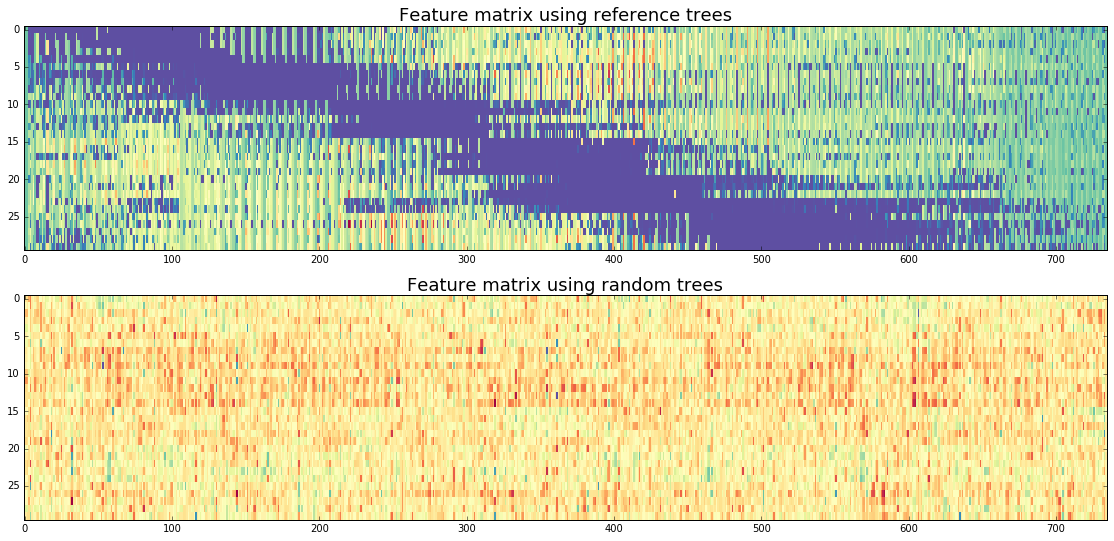

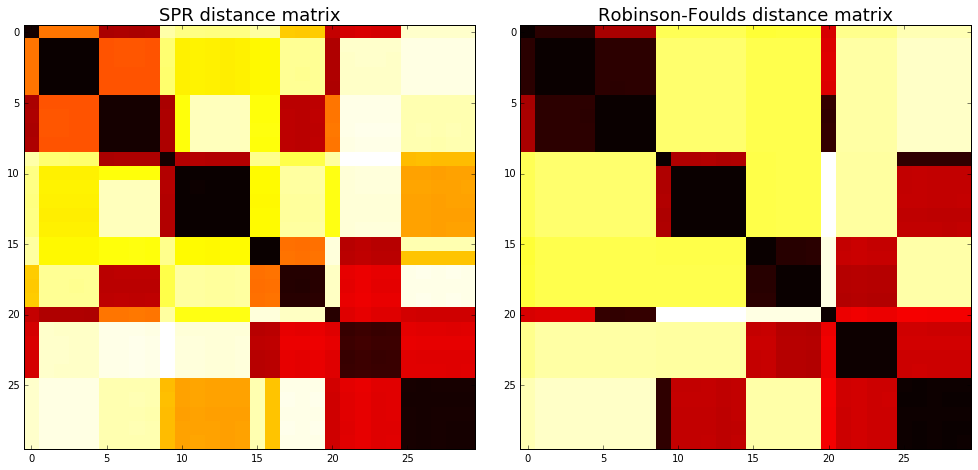

In [15]:
fig, axes = plt.subplots(2,1) ; fig.set_size_inches(16, 7)
fig.subplots_adjust(top=.99, bottom=.01, left=.03, right=.97, wspace=.1, hspace=.2)

im = axes[0].imshow(signal_full, aspect='auto', cmap="Spectral_r", interpolation="nearest")
axes[0].set_title("Feature matrix using reference trees",  fontsize=18)
im = axes[1].imshow(signal_rand, aspect='auto', cmap="Spectral_r", interpolation="nearest")
axes[1].set_title("Feature matrix using random trees",  fontsize=18)

fig, axes = plt.subplots(1,2) ; fig.set_size_inches(14, 6)
fig.subplots_adjust(top=.99, bottom=.01, left=.03, right=.97, wspace=.1, hspace=.1)
axes[0].imshow(dist1, aspect='auto', cmap="hot", interpolation="nearest")
axes[0].set_title("SPR distance matrix",  fontsize=18)
axes[1].imshow(dist2, aspect='auto', cmap="hot", interpolation="nearest")
axes[1].set_title("Robinson-Foulds distance matrix",  fontsize=18)

In [ ]:
fig, axes = plt.subplots(1) ; fig.set_size_inches(10, 6)
fig.subplots_adjust(top=.99, bottom=.01, left=.02, right=.98, wspace=.1, hspace=.1)
transf=manifold.MDS(n_components=2).fit_transform(signal_original)
axes.scatter(transf[:,1], transf[:,0], c=list(range(transf.shape[0])),edgecolor="black", alpha=.4, s=50)
axes.set_title("MDS of all original trees used in simulation")


### treeCl can normalize pairwise distances

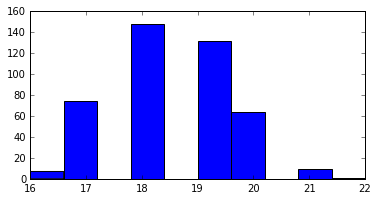

In [16]:
n_t = len(gt)
treecl_rf  = np.zeros((n_t,n_t)) ## square distance matrix
treecl_spr = np.zeros((n_t,n_t)) ## square distance matrix
dist_c = []
for i in range(n_t):
    for j in range (i):
        l_i = [x.label for x in gt[i].taxon_namespace]
        l_j = [x.label for x in gt[j].taxon_namespace]
        common =list(set(l_i) & set(l_j))
        n_c = len(common)
        dist_c.append(n_c)
        t_i = copy.deepcopy(gt[i])
        t_i.retain_taxa_with_labels(common)
        t_j = copy.deepcopy(gt[j])
        t_j.retain_taxa_with_labels(common)
        #print ("\n", l_i, "\n", l_j, "\n", common, "common")
        spc = treesignal.low_level_calculate_spectrum_from_tree_strings(
                t_i.as_string(schema="newick"), 
                t_j.as_string(schema="newick"))
        treecl_rf[i,j]  = treecl_rf[j,i]  = spc[5]/(n_c-3)
        treecl_spr[i,j] = treecl_spr[j,i] = (spc[3]+spc[4])/(2*n_c-3)
fig, axes = plt.subplots(1) ; fig.set_size_inches(6,3)
_ = axes.hist(dist_c)

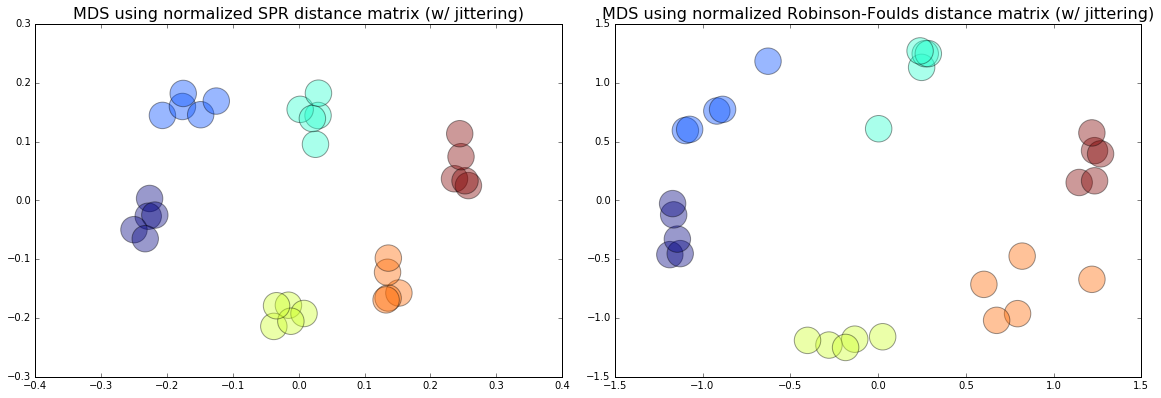

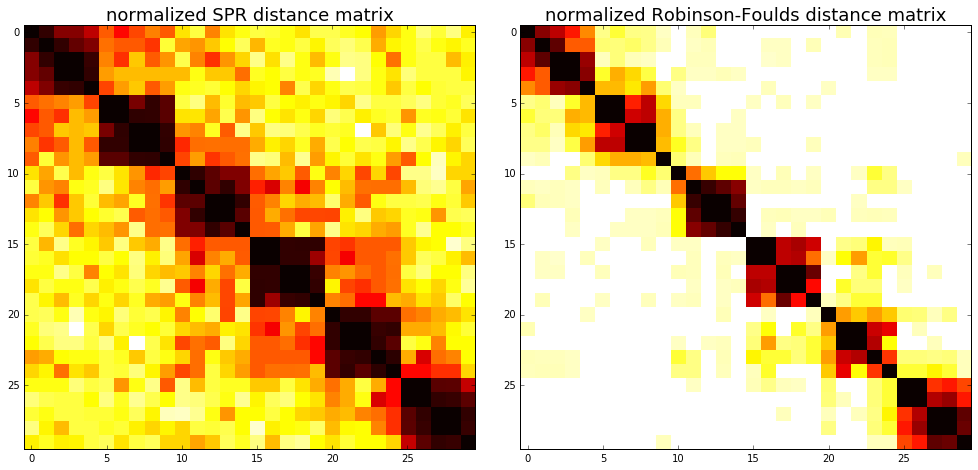

In [17]:
fig, axes = plt.subplots(1,2) ; fig.set_size_inches(16, 5)
fig.subplots_adjust(top=.99, bottom=.01, left=.02, right=.98, wspace=.1, hspace=.1)

transf=manifold.MDS(n_components=2, dissimilarity="precomputed").fit_transform(treecl_spr)
jit = 0.02 * transf.max() * np.random.normal(size=feat_miss.shape[0]) #  avoid complete overlap of points
axes[0].scatter(transf[:,1]+jit, transf[:,0]+jit[::-1], c=clabels, edgecolor="black", cmap="jet", alpha=.4, s=700)
axes[0].set_title("MDS using normalized SPR distance matrix (w/ jittering)",  fontsize=16)

transf=manifold.MDS(n_components=2, dissimilarity="precomputed").fit_transform(treecl_rf)
jit = 0.02 * transf.max() * np.random.normal(size=feat_miss.shape[0]) #  avoid complete overlap of points
axes[1].scatter(transf[:,1]+jit, transf[:,0]+jit[::-1], c=clabels, edgecolor="black", cmap="jet", alpha=.4, s=700)
axes[1].set_title("MDS using normalized Robinson-Foulds distance matrix (w/ jittering)",  fontsize=16)


fig, axes = plt.subplots(1,2) ; fig.set_size_inches(14, 6)
fig.subplots_adjust(top=.99, bottom=.01, left=.03, right=.97, wspace=.1, hspace=.1)
axes[0].imshow(treecl_spr, aspect='auto', cmap="hot", interpolation="nearest")
axes[0].set_title("normalized SPR distance matrix",  fontsize=18)
axes[1].imshow(treecl_rf, aspect='auto', cmap="hot", interpolation="nearest")
axes[1].set_title("normalized Robinson-Foulds distance matrix",  fontsize=18)